In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.utils import to_categorical

In [2]:
!wget https://github.com/Garasee/macine-learning/raw/main/datasets/car_eval.csv

--2024-06-17 12:07:36--  https://github.com/Garasee/macine-learning/raw/main/datasets/car_eval.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Garasee/macine-learning/main/datasets/car_eval.csv [following]
--2024-06-17 12:07:36--  https://raw.githubusercontent.com/Garasee/macine-learning/main/datasets/car_eval.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51884 (51K) [text/plain]
Saving to: ‘car_eval.csv’

car_eval.csv        100%[===================>]  50.67K  --.-KB/s    in 0.01s   

2024-06-17 12:07:36 (3.53 MB/s) - ‘car_eval.csv’ saved [51884/51884]



In [3]:
df = pd.read_csv('/content/car_eval.csv')

In [4]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [5]:
df.shape

(1727, 7)

In [5]:
def create_barplot(column, ax):
    counts = column.value_counts()
    counts.plot(kind='bar', ax=ax)
    ax.set_title(column.name)

In [7]:
# el = df[df['doors'] == "5more"].index

# df.drop(el, inplace=True)

In [6]:
df['buying'] = df['buying'].replace(['vhigh'], 'high')
df['buying'] = df['buying'].replace(['med'], 'low')

# df['safety'] = df['safety'].replace(['vhigh'], 'high')
# df['safety'] = df['safety'].replace(['med'], 'low')

df['maint'] = df['maint'].replace(['vhigh'], 'high')
df['maint'] = df['maint'].replace(['med'], 'low')

df['doors'] = df['doors'].replace(['5more'], 6)

df['persons'] = df['persons'].replace(['more'], 6)

df['class'] = df['class'].replace(['good', 'vgood'], 'acc')

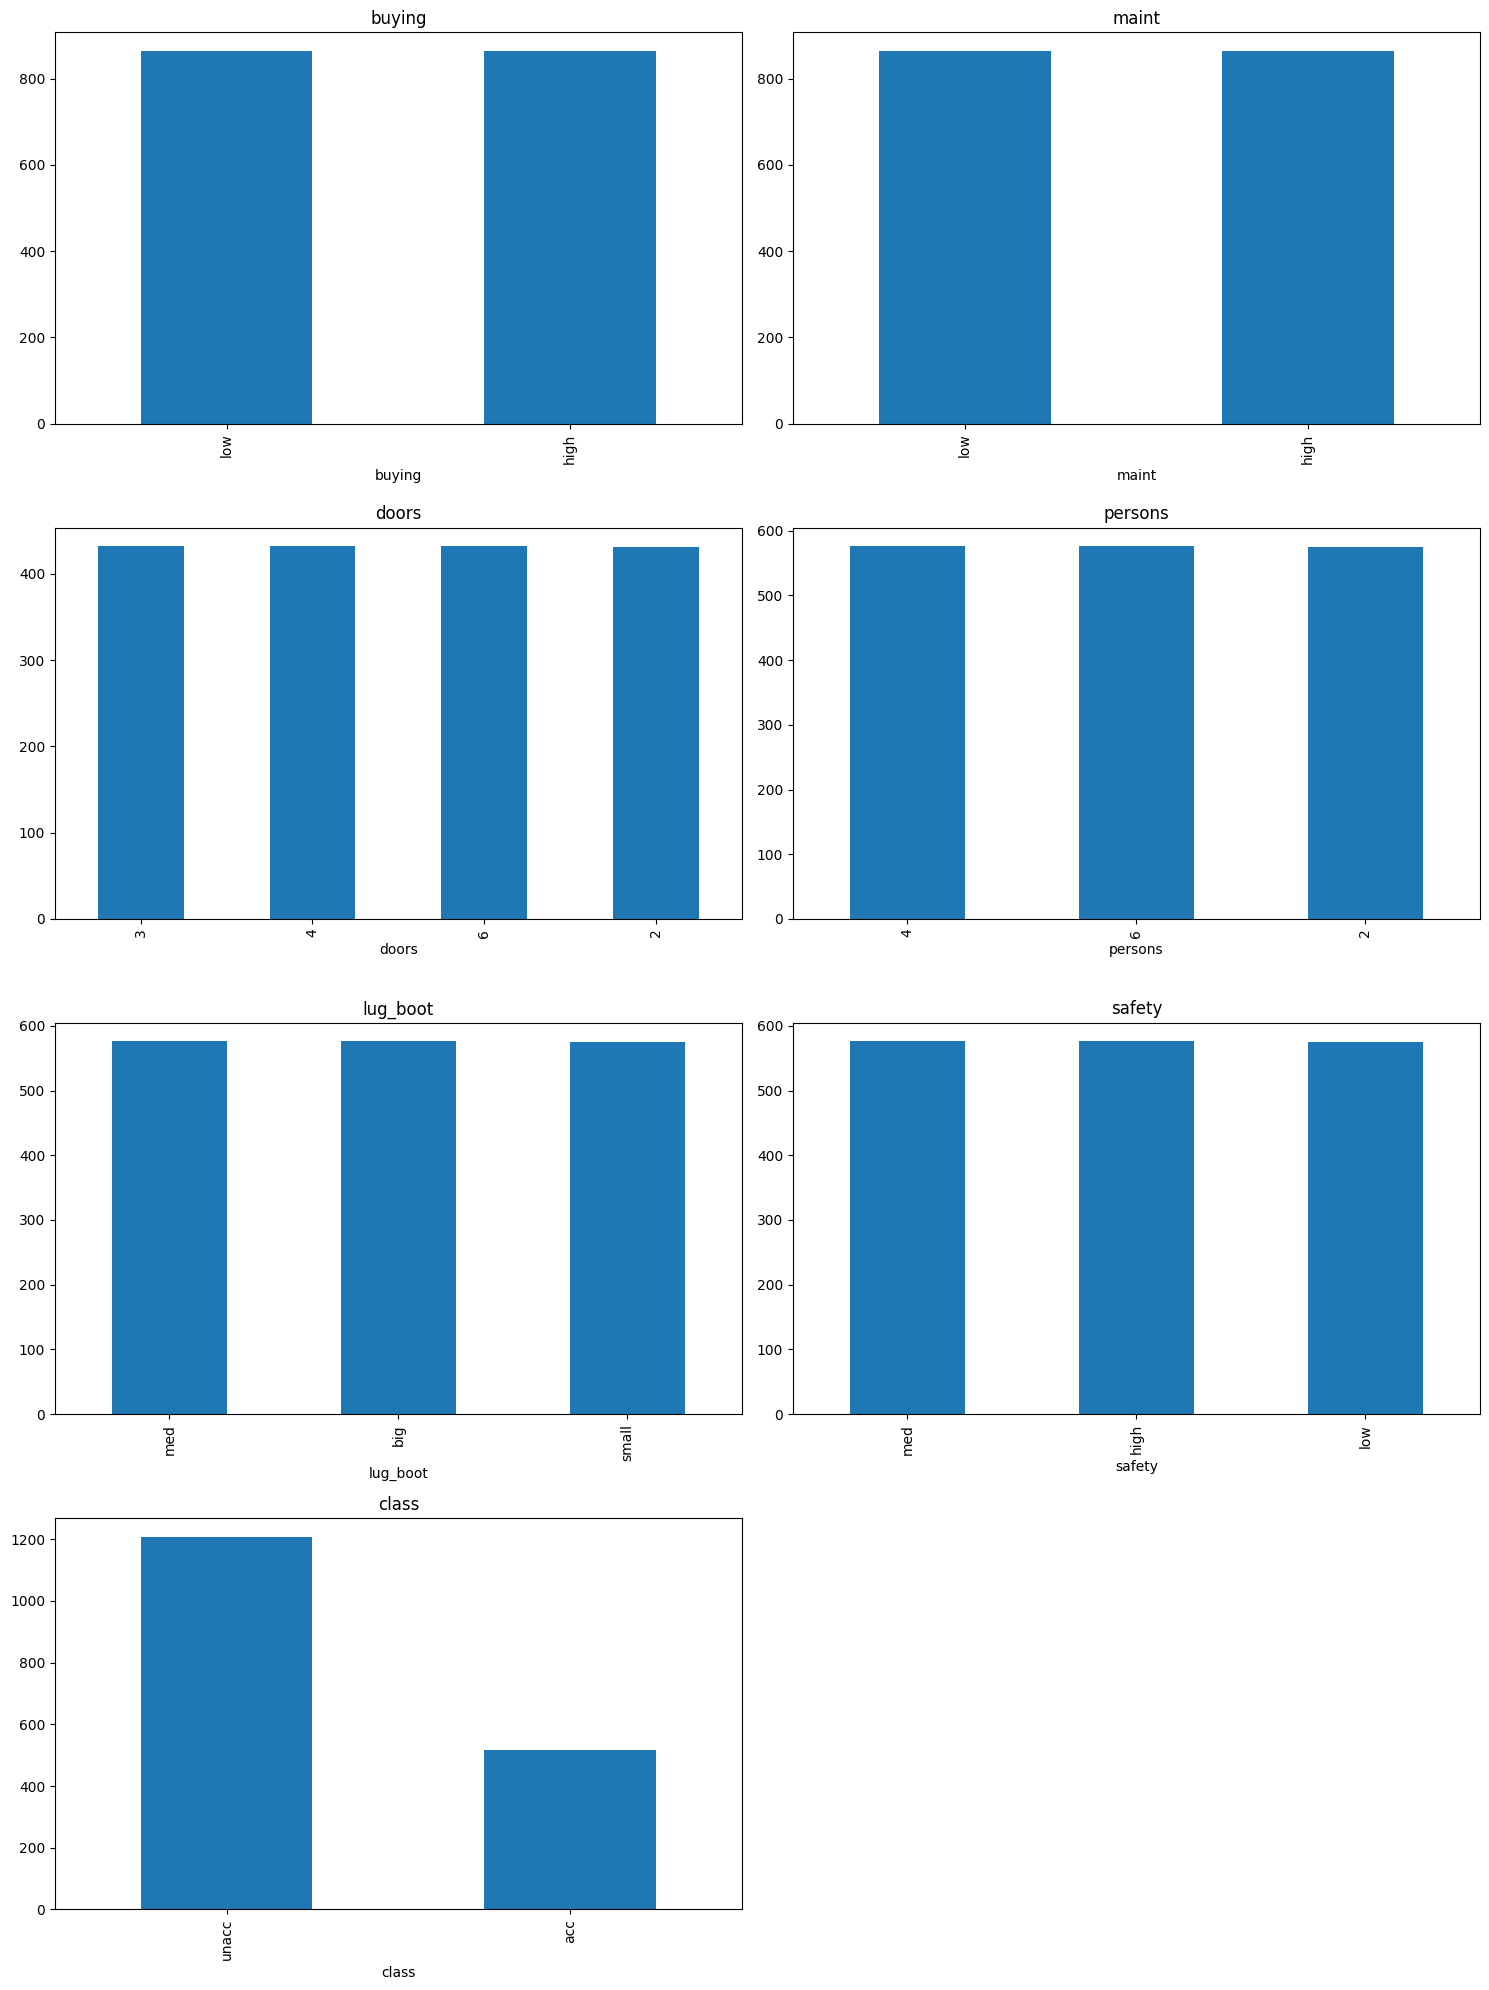

In [7]:
nrows, ncols = 4, 2

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 20))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    create_barplot(df[column], axes[i])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
df.columns

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], dtype='object')

In [9]:
df.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

In [10]:
df['doors'] = pd.to_numeric(df['doors'])
df['persons'] = pd.to_numeric(df['persons'])

In [11]:
df.dtypes

buying      object
maint       object
doors        int64
persons      int64
lug_boot    object
safety      object
class       object
dtype: object

In [12]:
categorical_features = ['buying', 'maint', 'lug_boot', 'safety', 'class']

encoders = dict()

def handle_encoding(df, columns):
    for column in columns:
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        df[column] = encoder.transform(df[column])

    return df

In [13]:
handle_encoding(df, categorical_features)

,buying,maint,doors,persons,lug_boot,safety,class
0,0,0,2,2,2,2,1
1,0,0,2,2,2,0,1
2,0,0,2,2,1,1,1
3,0,0,2,2,1,2,1
4,0,0,2,2,1,0,1
...,...,...,...,...,...,...,...
1722,1,1,6,6,1,2,0
1723,1,1,6,6,1,0,0
1724,1,1,6,6,0,1,1
1725,1,1,6,6,0,2,0


## Resample and add split data

In [14]:
X = df.drop(columns='class')
y = df['class']

In [15]:
from imblearn.over_sampling import SMOTE

resampler = SMOTE(sampling_strategy='minority')

X, y = resampler.fit_resample(X, y)

In [16]:
y.value_counts()

class
1    1209
0    1209
Name: count, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1934, 6) (484, 6) (1934,) (484,)


In [19]:
y_test

410     1
199     1
1673    1
1124    1
2285    0
       ..
2206    0
727     0
281     1
2009    0
1612    0
Name: class, Length: 484, dtype: int64

## Modelling

Tensorflow

In [24]:
model = Sequential(
    [
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

In [25]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    start_from_epoch=0,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

checkpoint_filepath = '/content/checkpoint.model.keras'

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=4,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/100
484/484 [==============================] - 3s 4ms/step - loss: 0.6231 - accuracy: 0.6732 - val_loss: 0.5168 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 2/100
484/484 [==============================] - 3s 6ms/step - loss: 0.5040 - accuracy: 0.7549 - val_loss: 0.4805 - val_accuracy: 0.7603 - lr: 1.0000e-04
Epoch 3/100
484/484 [==============================] - 2s 3ms/step - loss: 0.4461 - accuracy: 0.7787 - val_loss: 0.4670 - val_accuracy: 0.7624 - lr: 1.0000e-04
Epoch 4/100
484/484 [==============================] - 1s 3ms/step - loss: 0.3956 - accuracy: 0.8190 - val_loss: 0.3639 - val_accuracy: 0.8306 - lr: 1.0000e-04
Epoch 5/100
484/484 [==============================] - 2s 3ms/step - loss: 0.3306 - accuracy: 0.8526 - val_loss: 0.2953 - val_accuracy: 0.8657 - lr: 1.0000e-04
Epoch 6/100
484/484 [==============================] - 2s 3ms/step - loss: 0.2614 - accuracy: 0.8904 - val_loss: 0.2397 - val_accuracy: 0.8967 - lr: 1.0000e-04
Epoch 7/100
484/484 [===================

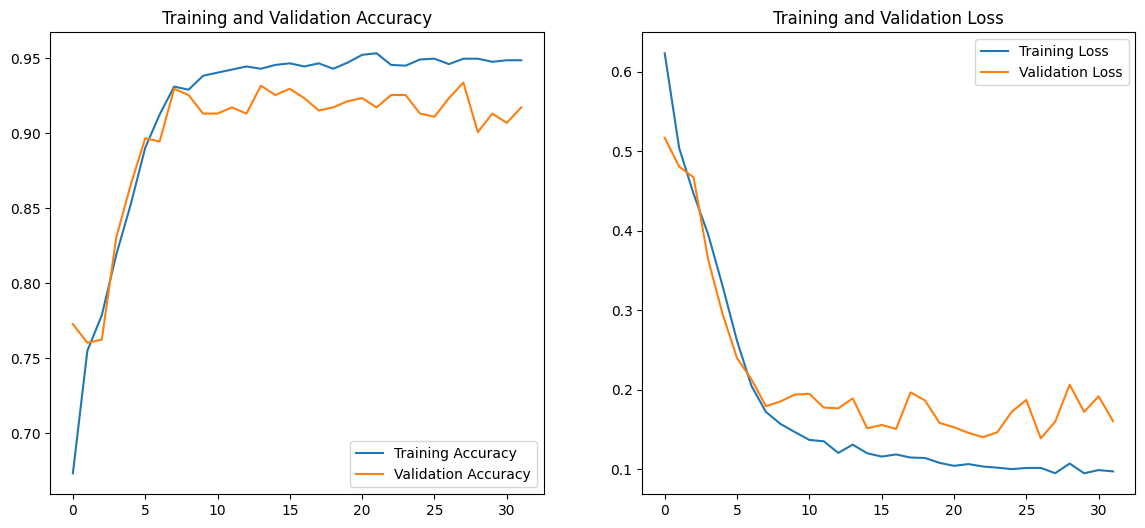

In [28]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs = range(len(acc))

plt.figure(figsize=(14, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plots
plt.show()

In [29]:
import joblib

model.save('model_v1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
os.makedirs('encoders', exist_ok=True)

for feature in categorical_features:
    filename = 'encoders/' + feature.lower() + '-encoders.h5'
    joblib.dump(encoders[feature], filename)